#### 安装Anaconda/Miniconda
* 下载Anaconda安装程序（Anaconda for Windows and Mac/ Miniconda for Linux）：[Anaconda/Miniconda](https://www.anaconda.com/download/success)
* 安装Anaconda
* 将Anaconda安装路径的condalib添加到环境变量PATH中（Windows）或将其添加到bashrc中（Mac and Linux）
* 启动控制台，创建虚拟环境 conda create -n rl python==3.8
* 关闭控制台后启动新的控制台，激活环境 conda activate rl

#### 安装Gym
* 进入rl虚拟环境后，通过pip安装gymnasium

In [1]:
! pip install "gymnasium"
! pip install "gymnasium[atari, accept-rom-license]"
! pip install matplotlib
! pip install numpy

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


#### 测试Gym安装结果

In [5]:
# 引入gym包
import gymnasium as gym
# 初始化强化学习环境
env = gym.make('CartPole-v1', render_mode='human')

gymnasium和gym包采用相似的API接口封装，为了兼容旧版gym环境，在包引入的时候将gymnasium包冲命名为gym

gym.make中的CartPole-v1是gym中的一个基础环境，具体支持的训练环境可参考：[gymnasium document](https://gymnasium.farama.org/)

render_mode可选human或rgb_array

In [7]:
observation, info = env.reset(seed=1)
print(observation)
print(info)
env.close()

[ 0.00118216  0.04504637 -0.03558404  0.04486495]
{}


此时屏幕中应该弹出一个CartPole环境的倒立摆环境，打印出的observation代表了此刻倒立摆的状态，具体的四个变量分别代表：[CartPole]（https://gymnasium.farama.org/environments/classic_control/cart_pole/）

reset表示环境重置或初始化，返回observation和环境信息。

虽然状态可以通过查询文档获知，但是一般下我们可以假设状态的内容是不可知的。

现在通过env.close关闭环境，注意这个命令在jupyter notebook中不起作用，但是在python文件中可以。

In [8]:
import gymnasium as gym

# 引入gym包
env = gym.make("CartPole-v1", render_mode="rgb_array")

#重置环境，返回观测和信息
observation, info = env.reset(seed=233)
episode_return = 0
return_list = []
for _ in range(10000):
    # 从行为空间中随机选择一个行为
    action = env.action_space.sample()

    # step函数表示应用该行为进行一步的推演；
    # 返回观测，刚刚行为的奖励，推演是否结束，该回合是否阶段，其他信息
    observation, reward, terminated, truncated, info = env.step(action)
    episode_return += reward

    # 如果回合结束或回合裁剪，重新启动一个环境。
    if terminated or truncated:
        observation, info = env.reset()
        return_list.append(episode_return)
        episode_return = 0
env.close()

当render_mode为rgb_array时，不弹出动画，此时的行为是随机行为。

我们可以采用matplotlib画出10000步内奖励的图

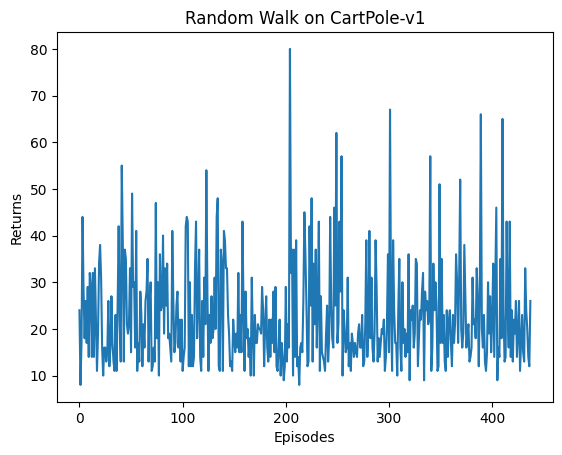

In [9]:
import matplotlib.pyplot as plt
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Random Walk on {}'.format('CartPole-v1'))
plt.show()

#### 实验1练习

实现爬山算法完成CartPole-v1任务

爬山算法：在当前最优的策略参数基础上随机探索

In [10]:
# 引入对应的包和实验环境
import gymnasium as gym
import numpy as np
from collections import deque

import time


env = gym.make('CartPole-v1', render_mode="rgb_array")
print('observation space:', env.observation_space)
print('action space:', env.action_space)
threshold = env.spec.reward_threshold
print('threshold: ', threshold)

observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
action space: Discrete(2)
threshold:  475.0


##### 定义policy
1. policy中维持一组维度为（state_space, action_space）的weight变量；
2. 在forward计算中计算weight * state，获得维度为action_space的结果；
3. 在forward的返回值中归一化计算选择每个action的概率：$\frac{e^{p_i}}{\sum_0^a{e^{p_i}}}$；
4. 在act中选择概率最大的行为。

In [11]:
class Policy():
    def __init__(self, s_size=4, a_size=2):
        self.w = 1e-4*np.random.rand(s_size, a_size)  # weights for simple linear policy: state_space x action_space
        
    def forward(self, state):
        x = np.dot(state, self.w)
        return np.exp(x)/sum(np.exp(x))
    
    def act(self, state):
        probs = self.forward(state)
        action = np.argmax(probs)          
        return action

policy = Policy()

##### 定义hill climbing函数

1. 维护一组最佳weight和最好结果
2. 在最佳weight上增加一定的噪声用来探索
3. 在增加噪声后的weight的基础上跑CartPole环境
4. 如果环境跑分比当前最好的结果好：则记录最佳评分和最佳weight，同时减半噪声范围，计算新的weight进行探索
5. 如果环境跑分比当前最好的结果差：则翻倍噪声范围，计算新的weight进行探索

In [12]:
def hill_climbing(n_episodes=10000, gamma=0.99, noise_scale=1e-2):

    scores_deque = deque(maxlen=100)
    scores = []
    best_Gt = -np.Inf
    best_w = policy.w

    for i_episode in range(1, n_episodes+1):
        rewards = []
        state, info = env.reset()
        timesteps = 0 
        
        while True:
            action = policy.act(state)
            state, reward, done, truncated, _ = env.step(action)            
            rewards.append(reward)
            timesteps += 1  
            if done or truncated:
                break 
        
        # 计算单局的收益，并加入到scores_deque中
        # TODO

        if total_reward >= best_Gt: 
            # 更新最大收益
            # 更新最佳权重
            # 调整噪声范围，减半噪声范围，但不能小于1e-3
            # TODO
            
            print('Ep.: {:3d} , timesteps: {:3d}, noise_scale (Gt >= best(Gt)): {:.4f}, Gt {:.4f}, \tAvg.Score:  {:.3f}'\
                  .format(i_episode, timesteps, noise_scale, total_reward, np.mean(scores_deque)))
            # 更新policy的权重
            # TODO
        else: 
            
            # 增大噪声范围，倍增噪声范围，最大不超过2
            print('Ep.: {:3d} , timesteps: {:3d}, noise_scale (Gt < best(Gt)): {:.4f}, Gt {:.4f}, \tAvg.Score:  {:.3f}'\
                  .format(i_episode, timesteps, noise_scale, total_reward, np.mean(scores_deque)))
            # 基于当前最优权重，更新policy的权重
              

        if np.mean(scores_deque)>=threshold:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            policy.w = best_w
            break
    
    return 


In [13]:
# 测试
hill_climbing()

env = gym.make('CartPole-v1', render_mode="human")
state, info=env.reset()
while True:
    time.sleep(0.01)
    action = policy.act(state)
    state, reward, done, trancate, _ = env.step(action)   
    if done or trancate:
        break

NameError: name 'total_reward' is not defined